Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

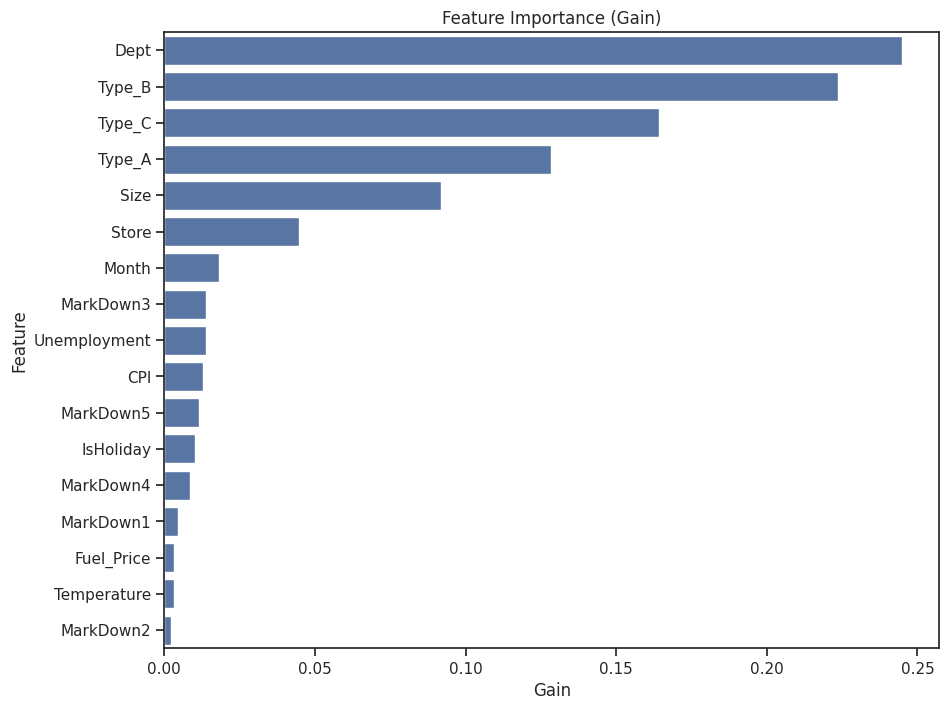

Selected important features:
1             Dept
14          Type_B
15          Type_C
13          Type_A
3             Size
0            Store
16           Month
8        MarkDown3
12    Unemployment
11             CPI
10       MarkDown5
2        IsHoliday
Name: Feature, dtype: object
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fittin

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import time
import psutil
import xgboost as xgb  # Import XGBoost
from skopt import BayesSearchCV  # Import Bayesian Optimization
import matplotlib.pyplot as plt

start_time = time.time()

# Load data
dataset = pd.read_csv("./input/train.csv", names=['Store','Dept','Date','weeklySales','IsHoliday'], sep=',', header=0)
features = pd.read_csv("./input/features.csv", sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday'])
stores = pd.read_csv("./input/stores.csv", names=['Store','Type','Size'], sep=',', header=0)

# Merge datasets
dataset = dataset.merge(stores, how='left').merge(features, how='left')

# Data preprocessing
imputer = SimpleImputer(strategy='mean')
dataset[['CPI', 'Fuel_Price', 'Unemployment', 'MarkDown3']] = imputer.fit_transform(dataset[['CPI', 'Fuel_Price', 'Unemployment', 'MarkDown3']])

# Convert categorical columns to dummy variables
dataset = pd.get_dummies(dataset, columns=["Type"])
dataset[['MarkDown1', 'MarkDown2', 'MarkDown4', 'MarkDown5']] = dataset[['MarkDown1', 'MarkDown2', 'MarkDown4', 'MarkDown5']].fillna(0)
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset = dataset.drop(columns=["Date"])

# Features and target
X = dataset.drop(columns=['weeklySales'])
y = dataset['weeklySales']

# Parameter space of Bayesian optimization
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# Bayesian optimization seeker
bayes_search = BayesSearchCV(
    xgb.XGBRegressor(n_jobs=-1),
    param_space,
    n_iter=32, 
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)

# Cross-validation
kf = KFold(n_splits=5)
splited = []

for name, group in dataset.groupby(["Store", "Dept"]):
    group = group.reset_index(drop=True)
    if group.shape[0] <= 5:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splited.append(group)

splited = pd.concat(splited).reset_index(drop=True)

# Bayesian optimization
bayes_search.fit(X, y)

# Get the best model
best_model = bayes_search.best_estimator_

# Calculate feature importance (using gain)
importance = best_model.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Gain': importance})
importance_df = importance_df.sort_values(by='Gain', ascending=False)

# Visualize feature importance (using gain)
plt.figure(figsize=(10, 8))
sns.barplot(x='Gain', y='Feature', data=importance_df)
plt.title('Feature Importance (Gain)')
plt.show()

# Select important features (assuming threshold of 0.01)
important_features = importance_df[importance_df['Gain'] > 0.009]['Feature']
X_important = X[important_features]

# Print selected features
print("Selected important features:")
print(important_features)

# Update data and retrain model
X_train, y_train = X_important, y
bayes_search = BayesSearchCV(
    xgb.XGBRegressor(n_jobs=-1),
    param_space,
    n_iter=32, 
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)

bayes_search.fit(X_train, y_train)
best_model = bayes_search.best_estimator_

# Recalculate cross-validation scores
error_cv = 0
best_error = np.iinfo(np.int32).max
best_mse = np.iinfo(np.int32).max
best_rmse = np.iinfo(np.int32).max
best_r2 = -np.inf

for fold in range(5):
    dataset_train = splited.loc[splited['fold'] != fold]
    dataset_test = splited.loc[splited['fold'] == fold]
    train_y = dataset_train['weeklySales']
    train_x = dataset_train[important_features]  
    test_y = dataset_test['weeklySales']
    test_x = dataset_test[important_features]  
    
    predicted = best_model.predict(test_x)
    mae, mse, rmse, r2 = mean_absolute_error(test_y, predicted), mean_squared_error(test_y, predicted), np.sqrt(mean_squared_error(test_y, predicted)), r2_score(test_y, predicted)
    error_cv += mae
    print(f"Fold {fold} MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")
    
    if mae < best_error:
        best_error = mae
        best_mse = mse
        best_rmse = rmse
        best_r2 = r2

error_cv /= 5
print(f'Cross-Validation MAE: {error_cv}')
print(f'Best MAE: {best_error}')
print(f'Best MSE: {best_mse}')
print(f'Best RMSE: {best_rmse}')
print(f'Best R²: {best_r2}')

# Predict on test data
dataset_test = pd.read_csv("./input/test.csv", names=['Store','Dept','Date','IsHoliday'], sep=',', header=0)
features = pd.read_csv("./input/features.csv", sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday'])
stores = pd.read_csv("./input/stores.csv", names=['Store','Type','Size'], sep=',', header=0)

dataset_test = dataset_test.merge(stores, how='left').merge(features, how='left')
dataset_test = pd.get_dummies(dataset_test, columns=["Type"])

# Rename 'IsHoliday' column to match training data
dataset_test = dataset_test.rename(columns={'IsHoliday': 'IsHoliday'})

# Fill missing values
dataset_test[['MarkDown1', 'MarkDown2', 'MarkDown4', 'MarkDown5']] = dataset_test[['MarkDown1', 'MarkDown2', 'MarkDown4', 'MarkDown5']].fillna(0)

# Extract month from the date and drop the date column
dataset_test['Month'] = pd.to_datetime(dataset_test['Date']).dt.month
dataset_test = dataset_test.drop(columns=["Date"])

# Ensure test data contains all columns in the training data
missing_cols = set(important_features) - set(dataset_test.columns)
for col in missing_cols:
    dataset_test[col] = 0

# Reorder columns to match the training data
dataset_test = dataset_test[important_features]

# Predict on test data
predicted_test = best_model.predict(dataset_test)
dataset_test['weeklySales'] = predicted_test

# Save results
dataset_test[['Store', 'Dept', 'weeklySales']].to_csv('output.csv', index=False)

# Compute and output runtime and resource usage
end_time = time.time()
elapsed_time = end_time - start_time
print(f"running time: {elapsed_time} seconds")

# Get CPU and memory usage
print(f"CPU utilization: {psutil.cpu_percent()}%")
print(f"memory usage: {psutil.virtual_memory().percent}%")
